## Importación de librerías

In [79]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import precision_score, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import xgboost as xgb




## Cargar archivos X_train y_train y X_test

In [64]:
# Leer el archivo CSV
X_train = pd.read_csv(r'C:\Users\Administrator\Documents\Proyecto Spaceship Titanic\spaceship_titanic_proyecto\Data\X_train.csv')
y_train = pd.read_csv(r'C:\Users\Administrator\Documents\Proyecto Spaceship Titanic\spaceship_titanic_proyecto\Data\y_train.csv')
X_test = pd.read_csv(r'C:\Users\Administrator\Documents\Proyecto Spaceship Titanic\spaceship_titanic_proyecto\Data\X_test.csv')

## Preprocesamiento para el modelo

In [72]:
#Hacer el encoding para X_train con one-hot-encoding:

X_train_encoded = pd.get_dummies(X_train, columns=['HomePlanet', 'Destination', 'CryoSleep', 'VIP'], drop_first=True)

# Convertir PassengerId a entero en X_train
X_train_encoded['PassengerId'] = X_train_encoded['PassengerId'].astype(int)

# Verificar valores no numéricos en PassengerId
non_numeric = pd.to_numeric(X_train_encoded['PassengerId'], errors='coerce')

# Contar los valores NaN que se han generado
num_nan = non_numeric.isna().sum()

print(f"Número de valores no numéricos en PassengerId para X_train: {num_nan}")


#Hacer el encoding para y_train con label encoding



# Crear y ajustar el codificador
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Crear un DataFrame con los valores originales y los codificados
mapping_df = pd.DataFrame({
    'Valor_Original': label_encoder.classes_,
    'Valor_Codificado': range(len(label_encoder.classes_))
})

# Verificar el mapeo
print(mapping_df)

# Ejemplo de cómo ver los resultados codificados
print("Valores codificados:", y_train_encoded)






#Hacer el encoding para X_test con one-hot-encoding:

X_test_encoded = pd.get_dummies(X_test, columns=['HomePlanet', 'Destination', 'CryoSleep', 'VIP'], drop_first=True)

# Convertir PassengerId a entero en X_test
X_test_encoded['PassengerId'] = X_test_encoded['PassengerId'].astype(int)


# Verificar valores no numéricos en PassengerId
non_numeric = pd.to_numeric(X_test_encoded['PassengerId'], errors='coerce')

# Contar los valores NaN que se han generado
num_nan = non_numeric.isna().sum()

print(f"Número de valores no numéricos en PassengerId para X_test: {num_nan}")



# Asegurarme de que ambos DataFrames tengan las mismas columnas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)





Número de valores no numéricos en PassengerId para X_train: 0
   Valor_Original  Valor_Codificado
0           False                 0
1            True                 1
Valores codificados: [0 1 0 ... 1 0 1]
Número de valores no numéricos en PassengerId para X_test: 0


c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Matriz de correlación

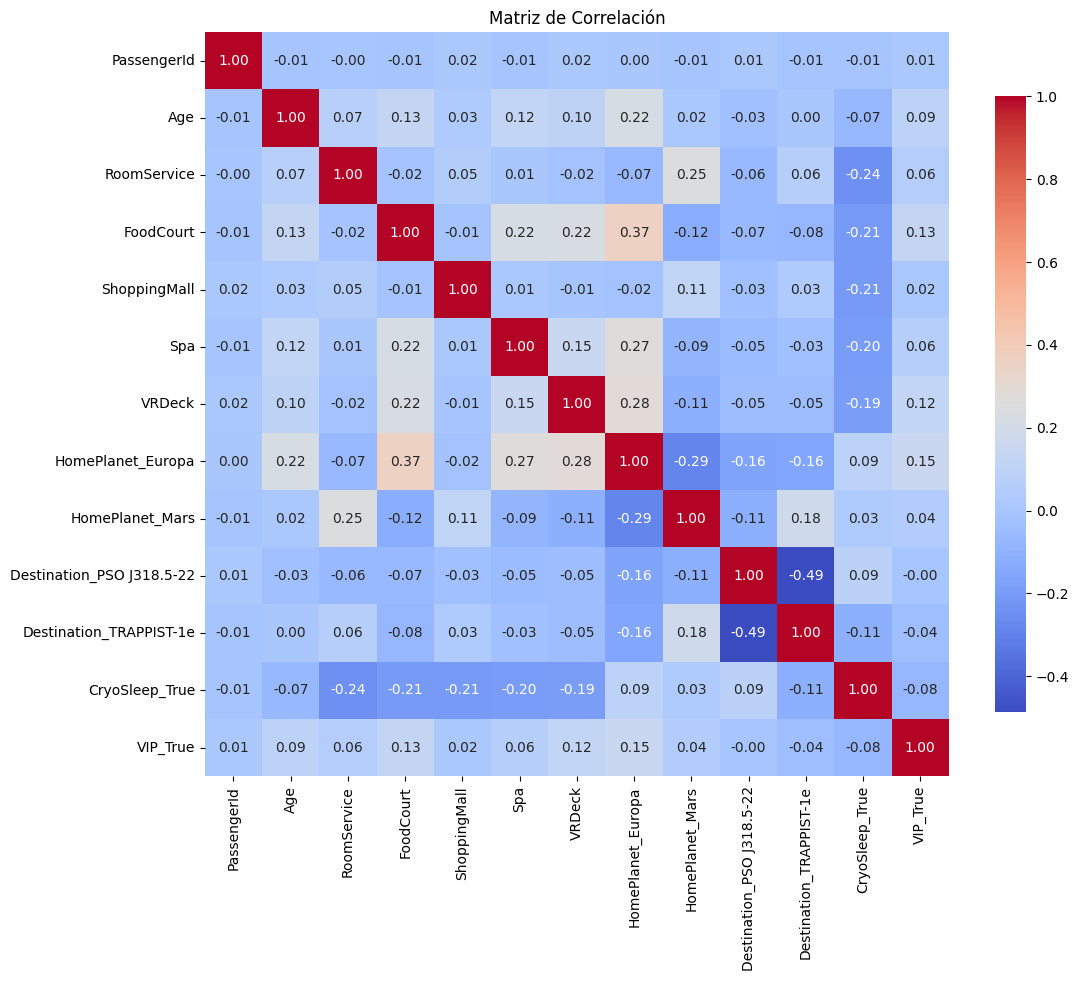

In [9]:


# Calcular la matriz de correlación
correlation_matrix = X_train_encoded.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 10))

# Crear un mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Configurar el título
plt.title('Matriz de Correlación')
plt.show()


## Estandarización de X_train_encoded

In [73]:
# Crear un escalador
scaler = StandardScaler()

# Identificar las columnas a estandarizar (todas menos 'PassengerId')
columns_to_scale = X_train_encoded.columns.difference(['PassengerId'])

# Aplicar la estandarización usando el DataFrame correcto
X_train_encoded[columns_to_scale] = scaler.fit_transform(X_train_encoded[columns_to_scale])

# Verificar los resultados
print(X_train_encoded.head())

   PassengerId       Age  RoomService  FoodCourt  ShoppingMall       Spa  \
0          101  0.709437    -0.340590  -0.287314     -0.290817 -0.276663   
1          201 -0.336717    -0.175364  -0.281669     -0.248968  0.211505   
2          301  2.034566    -0.275409   1.955616     -0.290817  5.694289   
3          302  0.290975    -0.340590   0.517406      0.330225  2.683471   
4          401 -0.894666     0.118709  -0.243409     -0.038048  0.225732   

     VRDeck  HomePlanet_Europa  HomePlanet_Mars  Destination_PSO J318.5-22  \
0 -0.269023           1.754795        -0.503664                  -0.317487   
1 -0.230194          -0.569867        -0.503664                  -0.317487   
2 -0.225782           1.754795        -0.503664                  -0.317487   
3 -0.098708           1.754795        -0.503664                  -0.317487   
4 -0.267258          -0.569867        -0.503664                  -0.317487   

   Destination_TRAPPIST-1e  CryoSleep_True  VIP_True  
0                 0

## Aplicar PCA

In [42]:

X_train_pca = X_train_encoded.drop(columns=['PassengerId'])

# Aplicar PCA
pca = PCA(n_components=8)  # Puedes ajustar el número de componentes según tus necesidades
X_pca = pca.fit_transform(X_train_encoded)

# Ahora X_pca contiene los datos transformados 

print(X_pca)


[[-4.63239480e+05  9.34381208e-01  1.91124083e-01 ...  4.88764870e-01
  -2.40984709e-01 -4.75611801e-01]
 [-4.63139480e+05 -3.10055975e-01  4.52116792e-01 ... -4.18001918e-01
  -6.79408963e-02  5.97845692e-02]
 [-4.63039480e+05  5.94575658e+00  1.56254416e+00 ... -3.79680725e-01
   1.22213533e+00  4.66969743e+00]
 ...
 [ 4.64560520e+05 -4.73206663e-01  1.13606637e+00 ...  1.86529702e+00
   1.25344186e+00 -4.04416691e-02]
 [ 4.64660520e+05  2.60919586e+00 -7.54872598e-01 ... -4.50303141e-01
   3.26659145e-01 -1.44188421e+00]
 [ 4.64661520e+05  2.34356155e+00  4.51138235e-01 ...  2.57006532e-01
  -5.36496573e-01 -2.40528806e-01]]


## Ajustar parámetros del XGBoost con X_train_encoded

In [29]:
#Definir los hiperparámetros que quieres ajustar

param_grid = {
    'n_estimators': [100, 300, 500],        # Número de árboles
    'max_depth': [3, 6, 10],                # Profundidad del árbol
    'learning_rate': [0.01, 0.1, 0.2],      # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],           # Fracción de muestras
    'colsample_bytree': [0.6, 0.8, 1.0],    # Fracción de características por árbol
    'gamma': [0, 0.1, 0.3],                 # Reducción mínima de la ganancia
    'reg_alpha': [0, 0.1, 1],               # Regularización L1
    'reg_lambda': [1, 0.1, 0]               # Regularización L2
}

#Crear el modelo XGBoost

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#Configurar la validación cruzada y GridSearchCV

# Usar StratifiedKFold para validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el GridSearchCV con la métrica de precisión
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring=make_scorer(precision_score),  # Métrica de evaluación
                           cv=skf, 
                           n_jobs=-1, 
                           verbose=1)

#Ajustar el modelo y encontrar los mejores hiperparámetros

# Ajustar el modelo con los datos codificados
grid_search.fit(X_train_encoded, y_train_encoded)

# Mostrar los mejores hiperparámetros y la mejor precisión
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_}")




Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}
Mejor precisión: 0.8119574176632705


c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Nota:
Recuerda que si has aplicado PCA a los datos, debes pasar X_pca en lugar de X_train_encoding si estás utilizando los datos después del PCA. en el codigo de arriba. Viene cross validation con los parametros recomendados.

## Validación cruzada XGBoost con X_train_encoded

In [30]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, make_scorer

# Inicializar el modelo XGBoost con los mejores hiperparámetros
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=0.1,
    subsample=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Configurar la validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el scorer basado en precisión
scorer = make_scorer(precision_score)

# Realizar la validación cruzada con precisión
scores = cross_val_score(xgb_model, X_train_encoded.drop(columns=['PassengerId']), y_train_encoded, cv=skf, scoring=scorer)

# Mostrar los resultados de validación cruzada
print(f"Puntajes de precisión en cada pliegue: {scores}")
print(f"Precisión promedio: {scores.mean()}")


c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parame

Puntajes de precisión en cada pliegue: [0.79113186 0.80148883 0.80496894 0.79564692 0.80225282]
Precisión promedio: 0.7990978731482843


ver los warnings

## Entrenamiento del modelo XGBoost con los parámetros recomendados

In [46]:

# Parámetros óptimos que encontrados
params = {
    'objective': 'binary:logistic',  # Objetivo de clasificación binaria
    'max_depth': 6,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'n_estimators': 1000,             # Número de árboles
    'reg_alpha': 1,                   # Regularización L1
    'reg_lambda': 1,                  # Regularización L2
    'eval_metric': 'logloss',         # Métrica de evaluación
    'seed': 42                        # Semilla aleatoria
}

# Crear un DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train_encoded, label=y_train_encoded)

# Entrenar el modelo
xgboost_model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])

# Guardar el modelo si lo deseas
xgboost_model.save_model('xgboost_model.json')

# Verificar que el modelo se ha entrenado correctamente
print("Modelo de XGBoost entrenado y guardado.")


c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Modelo de XGBoost entrenado y guardado.


## Obtener y_pred con X_test_encoded usando el modelo XGBoost

In [75]:
import pandas as pd
import xgboost as xgb

# Crear un DMatrix para X_test_encoded
dtest = xgb.DMatrix(X_test_encoded)

# Realizar las predicciones
y_pred = xgboost_model.predict(dtest)

# Ver las primeras predicciones
print("Primeras predicciones:\n", y_pred[:10])

# Convertir a booleano (1 es True y 0 es False)
y_pred_boolean = (y_pred > 0.5)  # Usar un umbral de 0.5 para convertir a booleano


Primeras predicciones:
 [0.6317442  0.00179316 0.9555399  0.96471846 0.34185085 0.38768348
 0.9968189  0.9905586  0.99682957 0.81319284]


## Crear resultado para enviar a Kaggel

In [78]:
# Cargar el conjunto de datos de prueba
test_df = pd.read_csv(r'C:\Users\Administrator\Documents\Proyecto Spaceship Titanic\spaceship_titanic_proyecto\Data\spaceship-titanic\test.csv')

# Cortar el DataFrame a las primeras 4277 filas
test_df_cortado = test_df.iloc[:4277]

# Convertir y_pred a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['Transported'])  

# Cortar y_pred_df a 4277 filas
y_pred_cortado = y_pred_df.iloc[:4277]

# Crear el DataFrame de envío
submission = pd.DataFrame({
    'PassengerId': test_df_cortado['PassengerId'],
    'Transported': y_pred_cortado['Transported']  
})

# Convertir Transported a booleano
submission['Transported'] = submission['Transported'].astype(bool)

# Guardar el DataFrame en un CSV
submission.to_csv('submission8.csv', index=False)

# Verificar el contenido del DataFrame de envío
print("Primeras filas del DataFrame de envío:\n", submission.head())

# Verificar el tipo de la columna PassengerId
print("Tipo de PassengerId en el DataFrame de envío:", submission['PassengerId'].dtype)

# Comprobar si todos los valores en PassengerId son strings
all_str = submission['PassengerId'].apply(lambda x: isinstance(x, str)).all()
print("¿Todos los valores en 'PassengerId' son str?:", all_str)

Primeras filas del DataFrame de envío:
   PassengerId  Transported
0     0013_01         True
1     0018_01         True
2     0019_01         True
3     0021_01         True
4     0023_01         True
Tipo de PassengerId en el DataFrame de envío: object
¿Todos los valores en 'PassengerId' son str?: True


In [ ]:
import pandas as pd
import numpy as np

# Suponiendo que ya tienes X_test_encoded y rf_model_final definidos

# Convertir PassengerId a string y verificar
X_test_encoded['PassengerId'] = X_test_encoded['PassengerId'].astype(str)
print("Tipo de PassengerId después de conversión inicial:", X_test_encoded['PassengerId'].dtype)

# Realizar las predicciones
y_pred = rf_model_final.predict(X_test_encoded.drop(columns=['PassengerId']))


Tipo de PassengerId después de conversión inicial: object


## Buscar mejores hiperparámetros para el XGBoost usando X_pca No components = 0.95

In [31]:
#Definir los hiperparámetros que quieres ajustar

param_grid = {
    'n_estimators': [100, 300, 500],        # Número de árboles
    'max_depth': [3, 6, 10],                # Profundidad del árbol
    'learning_rate': [0.01, 0.1, 0.2],      # Tasa de aprendizaje
    'subsample': [0.6, 0.8, 1.0],           # Fracción de muestras
    'colsample_bytree': [0.6, 0.8, 1.0],    # Fracción de características por árbol
    'gamma': [0, 0.1, 0.3],                 # Reducción mínima de la ganancia
    'reg_alpha': [0, 0.1, 1],               # Regularización L1
    'reg_lambda': [1, 0.1, 0]               # Regularización L2
}

#Crear el modelo XGBoost

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#Configurar la validación cruzada y GridSearchCV

# Usar StratifiedKFold para validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el GridSearchCV con la métrica de precisión
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring=make_scorer(precision_score),  # Métrica de evaluación
                           cv=skf, 
                           n_jobs=-1, 
                           verbose=1)

#Ajustar el modelo y encontrar los mejores hiperparámetros

# Ajustar el modelo con los datos codificados pca
grid_search.fit(X_pca, y_train_encoded)

# Mostrar los mejores hiperparámetros y la mejor precisión
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_}")

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Mejores parámetros: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.6}
Mejor precisión: 0.5434647603300995


c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Validación cruzada XGBoost con PCA

In [43]:

# Inicializar el modelo XGBoost con los mejores hiperparámetros
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    reg_alpha=1,
    reg_lambda=0.1,
    subsample=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Configurar la validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el scorer basado en precisión
scorer = make_scorer(precision_score)

# Realizar la validación cruzada con precisión utilizando X_pca y y_train_encoded
scores = cross_val_score(xgb_model, X_pca, y_train_encoded, cv=skf, scoring=scorer)

# Mostrar los resultados de validación cruzada
print(f"Puntajes de precisión en cada pliegue: {scores}")
print(f"Precisión promedio: {scores.mean()}")



c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Administrator\Documents\Proyecto Spaceship Titanic\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parame

Puntajes de precisión en cada pliegue: [0.80200501 0.77073171 0.78712871 0.75656325 0.76029963]
Precisión promedio: 0.7753456608022484
